In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as mpatches
import seaborn as sns
import itertools
%matplotlib inline

import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#init_notebook_mode(connected=True)

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
#from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import tree
#import lightgbm as lgb
#from lightgbm import LGBMClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split
from scipy import interp
from sklearn.metrics import classification_report, accuracy_score, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.metrics import confusion_matrix


import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
import time

seed=47

import os
#for dirname, _, filenames in os.walk('/Data'):
    #for filename in filenames:
       # print(os.path.join(dirname, filename))

# Importing Data

In [4]:
invoice_test = pd.read_csv('invoice_test.csv',low_memory=False)
invoice_train = pd.read_csv('invoice_train.csv',low_memory=False)
client_test = pd.read_csv('client_test.csv',low_memory=False)
client_train = pd.read_csv('client_train.csv',low_memory=False)
sample_submission = pd.read_csv('SampleSubmission (2).csv',low_memory=False)

# Basic Exploratory Data Analysis(EDA)

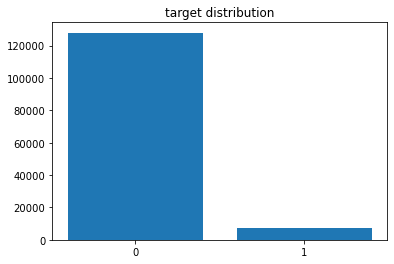

In [5]:
ds = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=ds.index, height=ds.values, tick_label =[0,1])
plt.title('target distribution')
plt.show()

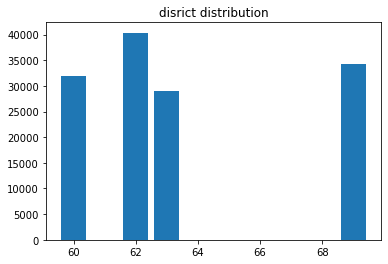

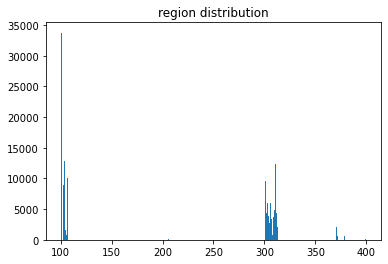

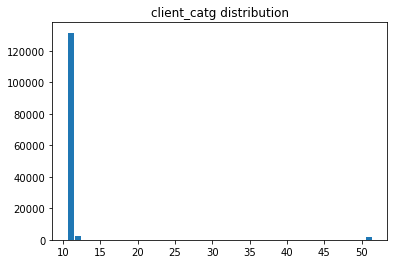

In [6]:
for col in ['disrict','region','client_catg']:
    ds = client_train.groupby([col])['client_id'].count()
    plt.bar(x=ds.index, height=ds.values)
    plt.title(col+' distribution')
    plt.show()

In [7]:
print('Number of missing rows in invoice_train:',invoice_train.isna().sum().sum())
print('Number of missing rows in invoice_test:',invoice_test.isna().sum().sum(),'\n')
print('Number of missing rows in client_train:',client_train.isna().sum().sum())
print('Number of missing rows in client_test:',client_test.isna().sum().sum())

Number of missing rows in invoice_train: 0
Number of missing rows in invoice_test: 0 

Number of missing rows in client_train: 0
Number of missing rows in client_test: 0


In [8]:
print('Number of unique values in invoice_train:')
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

Number of unique values in invoice_train:
client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 12
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


# Feature Engineering

In [9]:
def feature_change(cl, inv):

    cl['client_catg'] = cl['client_catg'].astype('category')
    cl['disrict'] = cl['disrict'].astype('category')
    cl['region'] = cl['region'].astype('category')
    cl['region_group'] = cl['region'].apply(lambda x: 100 if x<100 else 300 if x>300 else 200)
    cl['creation_date'] = pd.to_datetime(cl['creation_date'])
    
    cl['coop_time'] = (2019 - cl['creation_date'].dt.year)*12 - cl['creation_date'].dt.month

    inv['counter_type'] = inv['counter_type'].map({"ELEC":1,"GAZ":0})
    inv['counter_statue'] = inv['counter_statue'].map({0:0,1:1,2:2,3:3,4:4,5:5,769:5,'0':0,'5':5,'1':1,'4':4,'A':0,618:5,269375:5,46:5,420:5})
    
    inv['invoice_date'] = pd.to_datetime(inv['invoice_date'], dayfirst=True)
    inv['invoice_month'] = inv['invoice_date'].dt.month
    inv['invoice_year'] = inv['invoice_date'].dt.year
    inv['is_weekday'] = ((pd.DatetimeIndex(inv.invoice_date).dayofweek) // 5 == 1).astype(float)
    inv['delta_index'] = inv['new_index'] - inv['old_index']
    
    return cl, inv

In [10]:
client_train1, invoice_train1 = feature_change(client_train, invoice_train)
client_test1, invoice_test1 = feature_change(client_test, invoice_test)

In [11]:
def agg_feature(invoice, client_df, agg_stat):
    
    invoice['delta_time'] = invoice.sort_values(['client_id','invoice_date']).groupby('client_id')['invoice_date'].diff().dt.days.reset_index(drop=True)
    agg_trans = invoice.groupby('client_id')[agg_stat+['delta_time']].agg(['mean','std','min','max'])
    
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = invoice.groupby('client_id').size().reset_index(name='transactions_count')
    agg_trans = pd.merge(df, agg_trans, on='client_id', how='left')
    
    weekday_avg = invoice.groupby('client_id')[['is_weekday']].agg(['mean'])
    weekday_avg.columns = ['_'.join(col).strip() for col in weekday_avg.columns.values]
    weekday_avg.reset_index(inplace=True)
    client_df = pd.merge(client_df, weekday_avg, on='client_id', how='left')
    
    full_df = pd.merge(client_df, agg_trans, on='client_id', how='left')
    
    full_df['invoice_per_cooperation'] = full_df['transactions_count'] / full_df['coop_time']
    
    return full_df

In [12]:
agg_stat_columns = [
 'tarif_type',
 'counter_number',
 'counter_statue',
 'counter_code',
 'reading_remarque',
 'consommation_level_1',
 'consommation_level_2',
 'consommation_level_3',
 'consommation_level_4',
 'old_index',
 'new_index',
 'months_number',
 'counter_type',
 'invoice_month',
 'invoice_year',
 'delta_index'
]

train_df1 = agg_feature(invoice_train1, client_train1, agg_stat_columns)
test_df1 = agg_feature(invoice_test1, client_test1, agg_stat_columns)

In [13]:
def new_features(df):
    
    for col in agg_stat_columns:
        df[col+'_range'] = df[col+'_max'] - df[col+'_min']
        df[col+'_max_mean'] = df[col+'_max']/df[col+'_mean']
    
    return df

In [14]:
train_df2 = new_features(train_df1)
test_df2 = new_features(test_df1)

In [15]:
print('Initial number of columns: ', len(client_train.columns)+len(invoice_train.columns))
print('Number of columns now: ', len(train_df2.columns))

Initial number of columns:  29
Number of columns now:  111


In [16]:
def drop(df):

    col_drop = ['client_id', 'creation_date']
    for col in col_drop:
        df.drop([col], axis=1, inplace=True)
    return df

In [17]:
train_df = drop(train_df2)
test_df = drop(test_df2)

In [18]:
y = train_df['target']
X = train_df.drop('target',axis=1)

feature_name = X.columns.tolist()

drop_col=['reading_remarque_max','counter_statue_min','counter_type_min','counter_type_max','counter_type_range',
          'tarif_type_max', 'delta_index_min', 'consommation_level_4_mean']

X = X.drop(drop_col, axis=1)
test_df = test_df.drop(drop_col, axis=1)

In [19]:
drop_col=['reading_remarque_max','counter_statue_min','counter_type_min','counter_type_max','counter_type_range',
          'tarif_type_max', 'delta_index_min', 'consommation_level_4_mean']

X = X.drop(drop_col, axis=1)
test_df = test_df.drop(drop_col, axis=1)

In [23]:
def fitLGBM(trial,X, y):
    
    params={
      'n_estimators':trial.suggest_int('n_estimators', 0, 1000), 
      'num_leaves':trial.suggest_int('num_leaves', 2, 512),
      'max_depth':trial.suggest_int('max_depth', 2, 128),
      'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.15),
      'min_split_gain': trial.suggest_loguniform('min_split_gain', 0.001, 0.1),
      'feature_fraction':trial.suggest_uniform('feature_fraction',0.1, 1.0),
      'bagging_freq':trial.suggest_int('bagging_freq',0.1,10),
      'verbosity': -1,
      'random_state':seed
            }
    stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    model = LGBMClassifier(**params)
    
    res=[]
    for i, (tdx, vdx) in enumerate(stkfold.split(X, y)):
        X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y[tdx], y[vdx]
        model.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_valid, y_valid)],
                 early_stopping_rounds=30, verbose=False)
        preds = model.predict_proba(X_valid)
        res.append(roc_auc_score(y_valid, preds[:,1]))
    
    err = np.mean(res)
    
    return model, err

In [24]:
model = LGBMClassifier(random_state=seed, n_estimators=830,num_leaves=454, max_depth=61,
                       learning_rate=0.006910869038433314, min_split_gain=0.00667926424629105, 
                       feature_fraction=0.3764303138879782, bagging_freq=8)

stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

def calc(X, y, model, cv):
    res=[]
    local_probs=pd.DataFrame()
    probs = pd.DataFrame()

    for i, (tdx, vdx) in enumerate(cv.split(X, y)):
        X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y[tdx], y[vdx]
        model.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_valid, y_valid)],
                 early_stopping_rounds=30, verbose=False)
        
        preds = model.predict_proba(X_valid)
        oof_predict = model.predict_proba(test_df)
        local_probs['fold_%i'%i] = oof_predict[:,1]
        res.append(roc_auc_score(y_valid, preds[:,1]))

    print('ROC AUC:', round(np.mean(res), 6))    
    local_probs['res'] = local_probs.mean(axis=1)
    probs['target'] = local_probs['res']
    
    return probs

In [25]:
probs = calc(X, y, model, stkfold)

[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3764303138879782
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3764303138879782
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3764303138879782
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.3764303138879782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3764303138879782
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0

In [23]:
print('Proportion of the classes in the data:')
print(train_df['target'].value_counts()/len(train_df))

Proportion of the classes in the data:
0.0    0.944159
1.0    0.055841
Name: target, dtype: float64


Only 7566 (or 5.58%) of transaction are fraudulent. That means the data is highly imbalanced with respect with target variable Class.

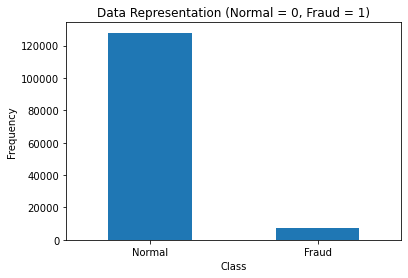

In [24]:
#Check data imbalance w.r.t target value: 'Class'

count_classes = pd.value_counts(train_df['target'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Data Representation (Normal = 0, Fraud = 1)")

LABELS = ["Normal", "Fraud"]
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

C:\Users\moinu\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\moinu\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


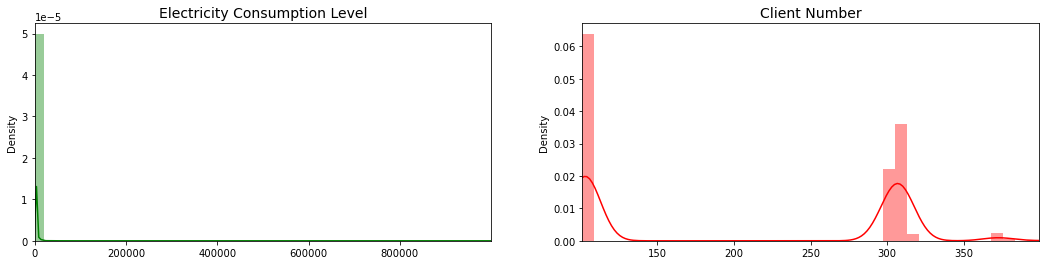

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

cons_val = train_df['consommation_level_1_max'].values
time_val = train_df2['region'].values

sns.distplot(cons_val, ax=ax[0], color='g')
ax[0].set_title('Electricity Consumption Level', fontsize=14)
ax[0].set_xlim([min(cons_val), max(cons_val)])

sns.distplot(time_val, ax=ax[1], color='r')
ax[1].set_title('Client Number', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])


plt.show()

In [26]:
tmp = train_df[['consommation_level_1_max','target']].copy()
class_0 = tmp.loc[tmp['target'] == 0]['consommation_level_1_max']
class_1 = tmp.loc[tmp['target'] == 1]['consommation_level_1_max']

In [27]:
class_0.describe()

count    127927.000000
mean       1318.940411
std        3318.667077
min           0.000000
25%         636.000000
50%        1088.000000
75%        1600.000000
max      999910.000000
Name: consommation_level_1_max, dtype: float64

In [28]:
class_1.describe()

count     7566.000000
mean      1759.797119
std       2067.729576
min          0.000000
25%        926.250000
50%       1401.500000
75%       2026.750000
max      62581.000000
Name: consommation_level_1_max, dtype: float64

In [33]:
train_df.shape

(135493, 109)

In [37]:
train_df.to_csv('df_train.csv')

In [68]:
df = pd.read_csv('df_train.csv',index_col=0)

<AxesSubplot:>

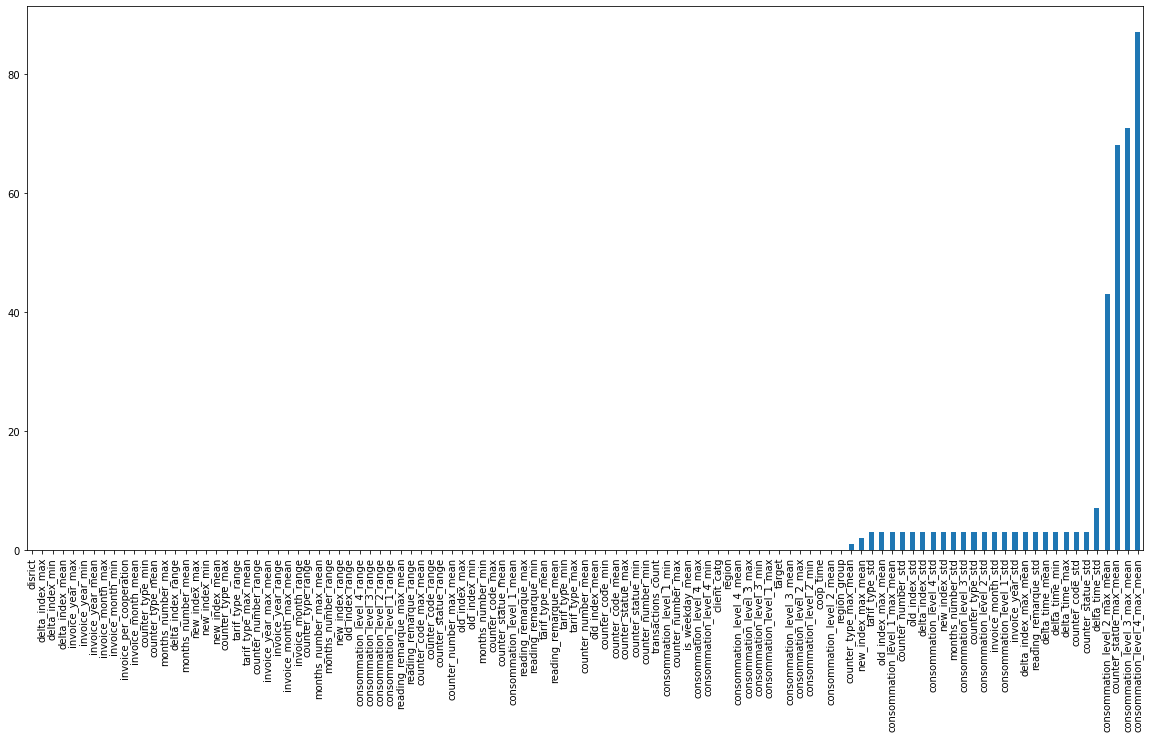

In [216]:
plt.figure(figsize=(20,10))
np.round(df.isnull().sum()/df.shape[0]*100).sort_values().plot(kind='bar')

# Scaling the Data

In [69]:

df = df.dropna(axis=1)
df


,disrict,client_catg,region,region_group,coop_time,is_weekday_mean,transactions_count,tarif_type_mean,tarif_type_min,tarif_type_max,...,new_index_range,months_number_range,months_number_max_mean,counter_type_range,invoice_month_range,invoice_month_max_mean,invoice_year_range,invoice_year_max_mean,delta_index_range,target
0,60,11,101,200,288,0.028571,35,11.000000,11,11,...,13269,10,2.592593,0,11,1.794872,14,1.003907,1348,0
1,69,11,107,200,199,0.054054,37,11.000000,11,11,...,20361,6,1.850000,0,9,1.947368,14,1.003560,1017,0
2,62,11,301,300,393,0.055556,18,11.000000,11,11,...,18640,8,1.862069,0,9,1.663866,14,1.004006,2894,0
3,69,11,105,200,265,0.050000,20,11.000000,11,11,...,24,2,1.428571,0,9,1.801802,7,1.001693,15,0
4,62,11,303,300,50,0.285714,14,11.000000,11,11,...,12770,2,1.076923,0,10,1.584906,4,1.001062,2258,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135488,62,11,304,300,173,0.014085,71,24.887324,11,40,...,14,6,1.893333,1,8,1.655012,14,1.003198,0,0
135489,63,11,311,300,74,0.000000,41,25.853659,11,40,...,6225,2,1.025000,1,8,1.653226,6,1.001573,831,0
135490,63,11,311,300,85,0.194444,36,22.277778,11,40,...,8989,4,1.945946,1,10,1.741935,7,1.002137,1042,0
135491,60,11,101,200,300,0.000000,2,10.000000,10,10,...,206,4,1.333333,0,4,1.200000,0,1.000000,329,0


In [70]:
df.isnull().sum().sum()

0

In [71]:
X = df.drop('target', axis=1)
y = df['target']

print(X.shape)
print(y.shape)

(135493, 73)
(135493,)


In [54]:
df = pd.concat([df, y], axis=1)

In [56]:
df

,disrict,client_catg,region,region_group,coop_time,is_weekday_mean,transactions_count,tarif_type_mean,tarif_type_min,tarif_type_max,...,new_index_range,months_number_range,months_number_max_mean,counter_type_range,invoice_month_range,invoice_month_max_mean,invoice_year_range,invoice_year_max_mean,delta_index_range,target
0,0.000000,0.0,0.000000,0.0,0.582524,0.028571,0.077626,0.034700,0.081081,0.028571,...,0.005252,0.000022,0.017515,0.0,1.000000,0.227106,1.000000,0.721412,0.001193,0
1,1.000000,0.0,0.020134,0.0,0.409709,0.054054,0.082192,0.034700,0.081081,0.028571,...,0.008059,0.000013,0.009348,0.0,0.818182,0.270677,1.000000,0.657374,0.000900,0
2,0.222222,0.0,0.671141,1.0,0.786408,0.055556,0.038813,0.034700,0.081081,0.028571,...,0.007378,0.000018,0.009481,0.0,0.818182,0.189676,1.000000,0.739702,0.002561,0
3,1.000000,0.0,0.013423,0.0,0.537864,0.050000,0.043379,0.034700,0.081081,0.028571,...,0.000009,0.000004,0.004713,0.0,0.818182,0.229086,0.500000,0.312570,0.000013,0
4,0.222222,0.0,0.677852,1.0,0.120388,0.285714,0.029680,0.034700,0.081081,0.028571,...,0.005055,0.000004,0.000846,0.0,0.909091,0.167116,0.285714,0.196191,0.001998,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135488,0.222222,0.0,0.681208,1.0,0.359223,0.014085,0.159817,0.428978,0.081081,0.857143,...,0.000006,0.000013,0.009825,1.0,0.727273,0.187146,1.000000,0.590568,0.000000,0
135489,0.333333,0.0,0.704698,1.0,0.166990,0.000000,0.091324,0.456413,0.081081,0.857143,...,0.002464,0.000004,0.000275,1.0,0.727273,0.186636,0.428571,0.290447,0.000735,0
135490,0.333333,0.0,0.704698,1.0,0.188350,0.194444,0.079909,0.354890,0.081081,0.857143,...,0.003558,0.000009,0.010403,1.0,0.909091,0.211982,0.500000,0.394622,0.000922,0
135491,0.000000,0.0,0.000000,0.0,0.605825,0.000000,0.002283,0.006309,0.054054,0.000000,...,0.000082,0.000009,0.003666,0.0,0.363636,0.057143,0.000000,0.000000,0.000291,0


In [57]:
not_fraud = df[(df['target'] == 0 )].count()[1]
fraud = df[(df['target'] == 1 )].count()[1]
print('No. of Non-fraudalent Cases: '+ str(not_fraud))
print('No. of Fraudalent Cases: '+ str(fraud))

No. of Non-fraudalent Cases: 127927
No. of Fraudalent Cases: 7566


In [58]:
# Since our classes are highly skewed, we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = df.sample(frac=1)

# amount of fraud classes 7566 rows.
fraud_df = df.loc[df['target'] == 1]
non_fraud_df = df.loc[df['target'] == 0][:7566]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)


In [59]:
new_df.head(5)

,disrict,client_catg,region,region_group,coop_time,is_weekday_mean,transactions_count,tarif_type_mean,tarif_type_min,tarif_type_max,...,new_index_range,months_number_range,months_number_max_mean,counter_type_range,invoice_month_range,invoice_month_max_mean,invoice_year_range,invoice_year_max_mean,delta_index_range,target
40861,1.000000,0.0,0.010067,0.0,0.174757,0.000000,0.086758,0.456928,0.081081,0.857143,...,0.017042,0.000018,0.016497,1.0,0.727273,0.154135,0.428571,0.295956,0.010083,1
95707,0.333333,0.0,0.711409,1.0,0.332039,0.169014,0.159817,0.394188,0.081081,0.857143,...,0.007707,0.000004,0.000319,1.0,1.000000,0.165079,1.000000,0.559459,0.000596,0
109289,0.222222,0.0,0.691275,1.0,0.040777,0.000000,0.006849,0.034700,0.081081,0.028571,...,0.000000,0.000002,0.001941,0.0,0.727273,0.153846,0.071429,0.045741,0.000000,0
107173,0.333333,0.0,0.687919,1.0,0.184466,0.407407,0.059361,0.553102,0.081081,0.857143,...,0.005636,0.000022,0.021104,1.0,0.909091,0.186589,0.500000,0.335959,0.000642,0
74717,0.222222,0.0,0.697987,1.0,0.299029,0.111111,0.038813,0.034700,0.081081,0.028571,...,0.015379,0.000063,0.047226,0.0,0.909091,0.349920,0.857143,0.775562,0.004406,1


In [60]:
print(new_df['target'].value_counts()/len(new_df)) #Equally Distributed

0    0.5
1    0.5
Name: target, dtype: float64


In [62]:
new_df.isnull().sum().sum()

27

In [63]:
new_df = new_df.dropna(axis=0)
new_df = new_df.dropna(axis=1)
new_df

,disrict,client_catg,region,region_group,coop_time,is_weekday_mean,transactions_count,tarif_type_mean,tarif_type_min,tarif_type_max,...,new_index_range,months_number_range,months_number_max_mean,counter_type_range,invoice_month_range,invoice_month_max_mean,invoice_year_range,invoice_year_max_mean,delta_index_range,target
40861,1.000000,0.0,0.010067,0.0,0.174757,0.000000,0.086758,0.456928,0.081081,0.857143,...,0.017042,0.000018,0.016497,1.0,0.727273,0.154135,0.428571,0.295956,0.010083,1
95707,0.333333,0.0,0.711409,1.0,0.332039,0.169014,0.159817,0.394188,0.081081,0.857143,...,0.007707,0.000004,0.000319,1.0,1.000000,0.165079,1.000000,0.559459,0.000596,0
109289,0.222222,0.0,0.691275,1.0,0.040777,0.000000,0.006849,0.034700,0.081081,0.028571,...,0.000000,0.000002,0.001941,0.0,0.727273,0.153846,0.071429,0.045741,0.000000,0
107173,0.333333,0.0,0.687919,1.0,0.184466,0.407407,0.059361,0.553102,0.081081,0.857143,...,0.005636,0.000022,0.021104,1.0,0.909091,0.186589,0.500000,0.335959,0.000642,0
74717,0.222222,0.0,0.697987,1.0,0.299029,0.111111,0.038813,0.034700,0.081081,0.028571,...,0.015379,0.000063,0.047226,0.0,0.909091,0.349920,0.857143,0.775562,0.004406,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23617,1.000000,0.0,0.020134,0.0,0.217476,0.222222,0.100457,0.400631,0.081081,0.857143,...,0.009279,0.000031,0.030678,1.0,0.909091,0.176219,0.642857,0.429838,0.005194,1
46074,0.000000,0.0,0.000000,0.0,0.242718,0.000000,0.027397,0.034700,0.081081,0.028571,...,0.012556,0.000013,0.008722,0.0,0.727273,0.216216,0.500000,0.303315,0.004691,0
23469,0.333333,0.0,0.704698,1.0,0.405825,0.088235,0.152968,0.397940,0.081081,0.857143,...,0.003285,0.000022,0.019117,1.0,0.727273,0.188153,1.000000,0.561213,0.000658,1
91832,1.000000,0.0,0.006711,0.0,0.112621,0.000000,0.011416,0.171924,0.081081,0.857143,...,0.000511,0.000018,0.014382,1.0,0.363636,0.285714,0.071429,0.076361,0.001142,1


In [64]:
#Train-Test-Split
X_new = new_df.drop('target', axis=1)
y_new = new_df['target']

X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=0)

X_train.shape, y_train.shape, X_test.shape , y_test.shape

((12084, 73), (12084,), (3021, 73), (3021,))

In [65]:
print("Number transactions X_train dataset: ", X_train.shape) 
print("Number transactions y_train dataset: ", y_train.shape) 
print("Number transactions X_test dataset: ", X_test.shape) 
print("Number transactions y_test dataset: ", y_test.shape) 

Number transactions X_train dataset:  (12084, 73)
Number transactions y_train dataset:  (12084,)
Number transactions X_test dataset:  (3021, 73)
Number transactions y_test dataset:  (3021,)


In [121]:
#LogisticRegression

lr = LogisticRegression()
predict(lr,X_train,y_train,X_test,y_test)

Training Accuracy: 93.9
Testing  Accuracy: 96.95


## 'LogisticRegression' object has no attribute 'feature_importances_'

In [122]:
#Logistic with SFS

sfs_1 = sfs_features(lr,(1,5))
sfs_1 = sfs_1.fit(X, y)
selectedFeatures = features(sfs_1)

#plot3D(sfs_1.k_feature_idx_[0],sfs_1.k_feature_idx_[1],sfs_1.k_feature_idx_[2],'knn')

X_train_sfs = sfs_1.transform(X_train)
X_test_sfs = sfs_1.transform(X_test)
print ('\n')
predict(lr,X_train_sfs,y_train,X_test_sfs,y_test,'sfs')

Selected features: (2, 5, 12, 13, 15)
V1
V4
V11
V12
V14


Training Accuracy: 92.76
Testing  Accuracy: 97.97


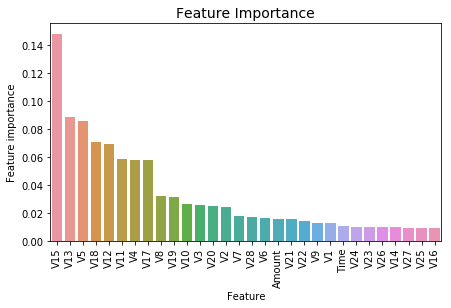

In [131]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

#Feature Importance

tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': etc.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Feature Importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [133]:
#Extra Trees Classifier with SFS

sfs_1 = sfs_features(etc,(1,5))
sfs_1 = sfs_1.fit(X, y)
selectedFeatures = features(sfs_1)

#plot3D(sfs_1.k_feature_idx_[0],sfs_1.k_feature_idx_[1],sfs_1.k_feature_idx_[2],'knn')

X_train_sfs = sfs_1.transform(X_train)
X_test_sfs = sfs_1.transform(X_test)
print ('\n')
predict(etc,X_train_sfs,y_train,X_test_sfs,y_test,'sfs')

Selected features: (2, 5, 15, 17, 29)
V1
V4
V14
V16
V28


Training Accuracy: 100.0
Testing  Accuracy: 98.48


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       106
           1       0.99      0.98      0.98        91

    accuracy                           0.98       197
   macro avg       0.99      0.98      0.98       197
weighted avg       0.98      0.98      0.98       197



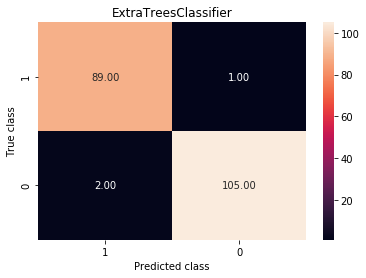

In [134]:
print(classification_report(y_test, etc.predict(X_test_sfs)))
conf(etc,X_test_sfs, y_test)

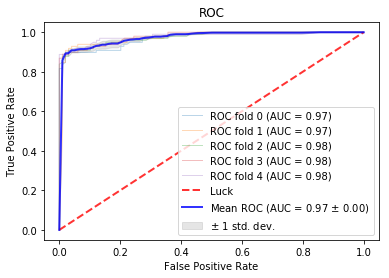

In [136]:
roc_graph_cv(etc,X[:,selectedFeatures],y)

In [137]:
#  Descion Tree

dect = tree.DecisionTreeClassifier()
predict(dect,X_train,y_train,X_test,y_test)

Training Accuracy: 100.0
Testing  Accuracy: 93.91


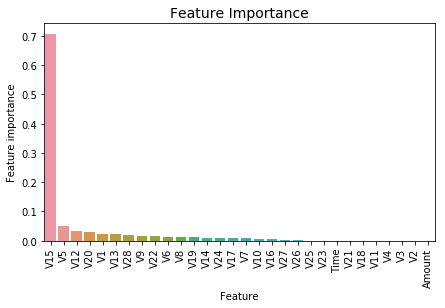

In [138]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

#Feature Importance

tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': dect.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Feature Importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [147]:
#Decision Tree with SFS

sfs_1 = sfs_features(dect,(1,5))
sfs_1 = sfs_1.fit(X, y)
selectedFeatures = features(sfs_1)

#plot3D(sfs_1.k_feature_idx_[0],sfs_1.k_feature_idx_[1],sfs_1.k_feature_idx_[2],'knn')

X_train_sfs = sfs_1.transform(X_train)
X_test_sfs = sfs_1.transform(X_test)
print ('\n')
predict(dect,X_train_sfs,y_train,X_test_sfs,y_test,'sfs')

Selected features: (5, 15, 19, 24)
V4
V14
V18
V23


Training Accuracy: 100.0
Testing  Accuracy: 91.37


              precision    recall  f1-score   support

           0       0.96      0.88      0.92       106
           1       0.87      0.96      0.91        91

    accuracy                           0.91       197
   macro avg       0.91      0.92      0.91       197
weighted avg       0.92      0.91      0.91       197



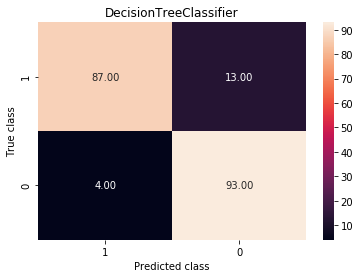

In [148]:
print(classification_report(y_test, dect.predict(X_test_sfs)))
conf(dect,X_test_sfs, y_test)

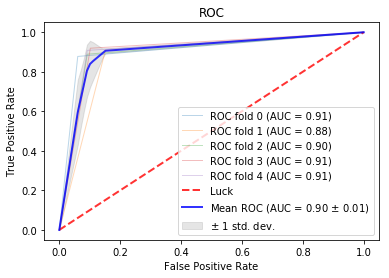

In [149]:
roc_graph_cv(dect,X[:,selectedFeatures],y)

In [166]:
#Support Vector Classifier_Linear

svc = SVC(kernel='linear', probability=True)
predict(svc,X_train,y_train,X_test,y_test, 'linear')

Training Accuracy: 94.16
Testing  Accuracy: 97.46


In [167]:
#Support Vector Classifier_Poly

svc = SVC(kernel='poly', probability=True)
predict(svc,X_train,y_train,X_test,y_test, 'poly')

Training Accuracy: 87.29
Testing  Accuracy: 89.85


In [168]:
#Support Vector Classifier_rbf

svc = SVC(kernel='rbf', probability=True)
predict(svc,X_train,y_train,X_test,y_test, 'rbf')

Training Accuracy: 93.01
Testing  Accuracy: 96.95


## 'SVC' object has no attribute 'feature_importance_'

In [169]:
#Support Vector Classifier with SFS

sfs_1 = sfs_features(svc,(1,5))
sfs_1 = sfs_1.fit(X, y)
selectedFeatures = features(sfs_1)

#plot3D(sfs_1.k_feature_idx_[0],sfs_1.k_feature_idx_[1],sfs_1.k_feature_idx_[2],'knn')

X_train_sfs = sfs_1.transform(X_train)
X_test_sfs = sfs_1.transform(X_test)
print ('\n')
predict(svc,X_train_sfs,y_train,X_test_sfs,y_test,'sfs')

Selected features: (5, 8, 13, 15, 21)
V4
V7
V12
V14
V20


Training Accuracy: 92.88
Testing  Accuracy: 98.48


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       106
           1       0.99      0.98      0.98        91

    accuracy                           0.98       197
   macro avg       0.99      0.98      0.98       197
weighted avg       0.98      0.98      0.98       197



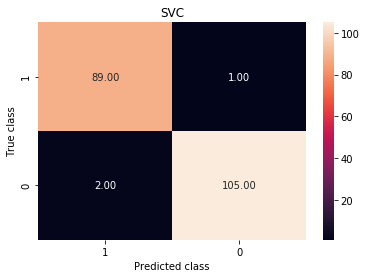

In [170]:
print(classification_report(y_test, svc.predict(X_test_sfs)))
conf(svc,X_test_sfs, y_test)

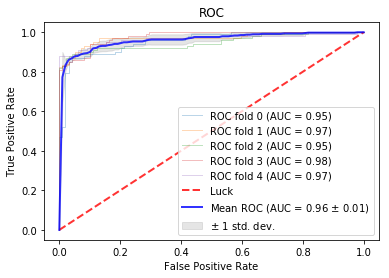

In [172]:
roc_graph_cv(svc,X[:,selectedFeatures],y)

In [150]:
# Gradient Boosting

gbc = GradientBoostingClassifier(loss='exponential', learning_rate=0.03, n_estimators=75 , max_depth=6)
predict(gbc,X_train,y_train,X_test,y_test)

Training Accuracy: 99.75
Testing  Accuracy: 93.91


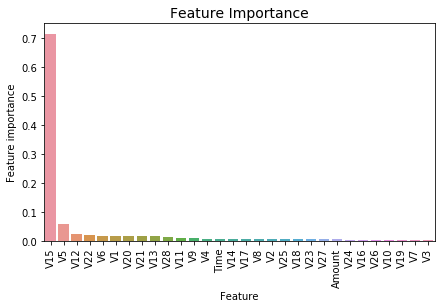

In [152]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

#Feature Importance

tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': gbc.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Feature Importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [151]:
# Gradient Boosting with SFS

sfs_1 = sfs_features(dect,(1,5))
sfs_1 = sfs_1.fit(X, y)
selectedFeatures = features(sfs_1)

#plot3D(sfs_1.k_feature_idx_[0],sfs_1.k_feature_idx_[1],sfs_1.k_feature_idx_[2],'knn')

X_train_sfs = sfs_1.transform(X_train)
X_test_sfs = sfs_1.transform(X_test)
print ('\n')
predict(dect,X_train_sfs,y_train,X_test_sfs,y_test,'sfs')

Selected features: (4, 6, 9, 15, 29)
V3
V5
V8
V14
V28


Training Accuracy: 100.0
Testing  Accuracy: 90.86


              precision    recall  f1-score   support

           0       0.96      0.87      0.91       106
           1       0.86      0.96      0.91        91

    accuracy                           0.91       197
   macro avg       0.91      0.91      0.91       197
weighted avg       0.91      0.91      0.91       197



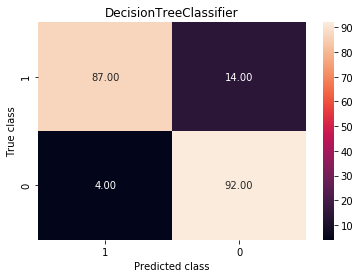

In [153]:
print(classification_report(y_test, dect.predict(X_test_sfs)))
conf(dect,X_test_sfs, y_test)

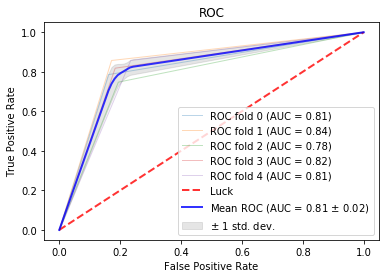

In [154]:
roc_graph_cv(dect,X[:,selectedFeatures],y)

In [180]:
#XGBoost

import xgboost as xgb

xg = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc")
predict(xg,X_train,y_train,X_test,y_test)

Training Accuracy: 100.0
Testing  Accuracy: 95.94


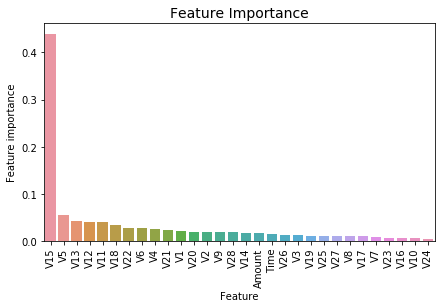

In [181]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

#Feature Importance

tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': xg.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Feature Importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [194]:
#XGBoost with SFS

sfs_1 = sfs_features(xg,(1,5))
sfs_1 = sfs_1.fit(X, y)
selectedFeatures = features(sfs_1)

#plot3D(sfs_1.k_feature_idx_[0],sfs_1.k_feature_idx_[1],sfs_1.k_feature_idx_[2],'knn')

X_train_sfs = sfs_1.transform(X_train)
X_test_sfs = sfs_1.transform(X_test)
print ('\n')
predict(xg,X_train_sfs,y_train,X_test_sfs,y_test,'sfs')

Selected features: (5, 8, 11, 14, 15)
V4
V7
V10
V13
V14


Training Accuracy: 100.0
Testing  Accuracy: 94.42


              precision    recall  f1-score   support

           0       0.97      0.92      0.95       106
           1       0.92      0.97      0.94        91

    accuracy                           0.94       197
   macro avg       0.94      0.95      0.94       197
weighted avg       0.95      0.94      0.94       197



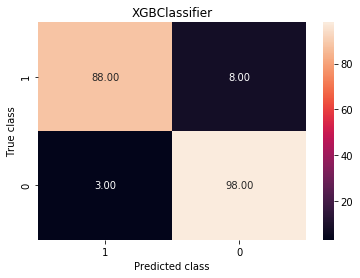

In [195]:
print(classification_report(y_test, xg.predict(X_test_sfs)))
conf(xg,X_test_sfs, y_test)

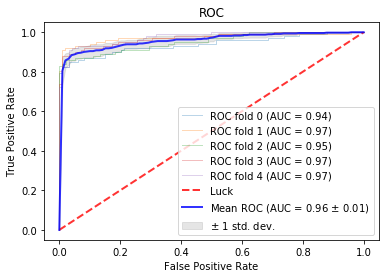

In [196]:
roc_graph_cv(xg,X[:,selectedFeatures],y)

In [188]:
#AdaBoost Classifier

ada = AdaBoostClassifier(n_estimators=100, random_state=0)
predict(ada,X_train,y_train,X_test,y_test)

Training Accuracy: 100.0
Testing  Accuracy: 93.4


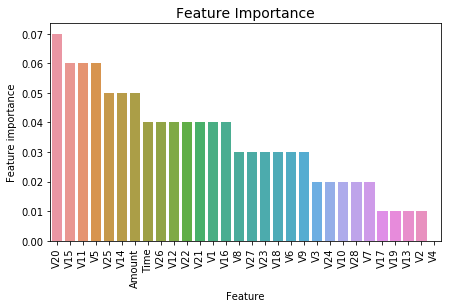

In [189]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

#Feature Importance

tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': ada.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Feature Importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [190]:
#AdaBoost with SFS

sfs_1 = sfs_features(ada,(1,5))
sfs_1 = sfs_1.fit(X, y)
selectedFeatures = features(sfs_1)

#plot3D(sfs_1.k_feature_idx_[0],sfs_1.k_feature_idx_[1],sfs_1.k_feature_idx_[2],'knn')

X_train_sfs = sfs_1.transform(X_train)
X_test_sfs = sfs_1.transform(X_test)
print ('\n')
predict(ada,X_train_sfs,y_train,X_test_sfs,y_test,'sfs')

Selected features: (4, 5, 13, 15)
V3
V4
V12
V14


Training Accuracy: 97.2
Testing  Accuracy: 96.95


              precision    recall  f1-score   support

           0       0.98      0.96      0.97       106
           1       0.96      0.98      0.97        91

    accuracy                           0.97       197
   macro avg       0.97      0.97      0.97       197
weighted avg       0.97      0.97      0.97       197



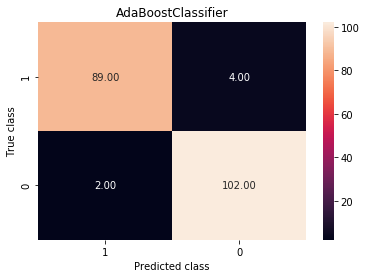

In [191]:
print(classification_report(y_test, ada.predict(X_test_sfs)))
conf(ada,X_test_sfs, y_test)

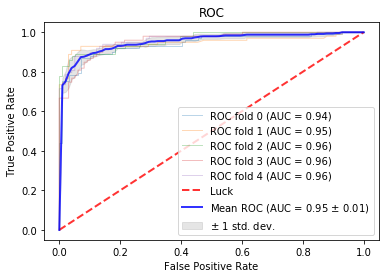

In [192]:
roc_graph_cv(ada,X[:,selectedFeatures],y)

The optimal number of neighbors is 2 with 92.5%


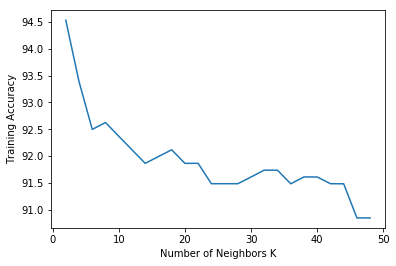

In [204]:
from sklearn import model_selection

#Neighbors
neighbors = [x for x in list(range(1,50)) if x % 2 == 0]

#Create empty list that will hold cv scores
cv_scores = []

#Perform 10-fold cross validation on training set for odd values of k:
seed=123
for k in neighbors:
    k_value = k+1
    knn = KNeighborsClassifier(n_neighbors = k_value, weights='uniform', p=2, metric='euclidean')
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    scores = model_selection.cross_val_score(knn, X_train, y_train, cv=kfold, scoring='accuracy')
    cv_scores.append(scores.mean()*100)
    #print("k=%d %0.2f (+/- %0.2f)" % (k_value, scores.mean()*100, scores.std()*100))

    optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print(( "The optimal number of neighbors is %d with %0.1f%%" % (optimal_k, cv_scores[optimal_k])))

plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Training Accuracy')
plt.show()

In [200]:
# K Neighbours Classifier

knn = KNeighborsClassifier()
predict(knn,X_train,y_train,X_test,y_test)

Training Accuracy: 95.93
Testing  Accuracy: 95.94


## 'KNeighborsClassifier' object has no attribute 'feature_importances_'

In [201]:
# K Neighbours Classifier with SFS

sfs_1 = sfs_features(knn,(1,5))
sfs_1 = sfs_1.fit(X, y)
selectedFeatures = features(sfs_1)

#plot3D(sfs_1.k_feature_idx_[0],sfs_1.k_feature_idx_[1],sfs_1.k_feature_idx_[2],'knn')

X_train_sfs = sfs_1.transform(X_train)
X_test_sfs = sfs_1.transform(X_test)
print ('\n')
predict(knn,X_train_sfs,y_train,X_test_sfs,y_test,'sfs')

Selected features: (2, 5, 15, 28)
V1
V4
V14
V27


Training Accuracy: 94.92
Testing  Accuracy: 95.43


              precision    recall  f1-score   support

           0       0.94      0.98      0.96       106
           1       0.98      0.92      0.95        91

    accuracy                           0.95       197
   macro avg       0.96      0.95      0.95       197
weighted avg       0.96      0.95      0.95       197



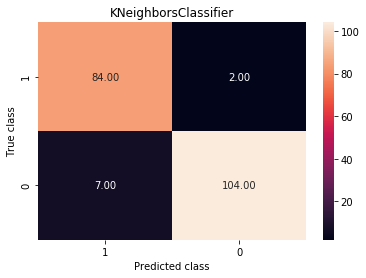

In [202]:
print(classification_report(y_test, knn.predict(X_test_sfs)))
conf(knn,X_test_sfs, y_test)

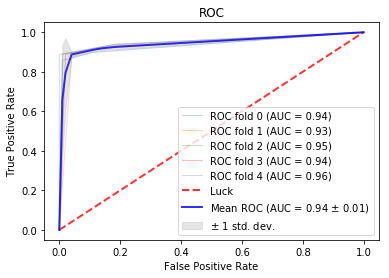

In [203]:
roc_graph_cv(knn,X[:,selectedFeatures],y)

In [207]:
# Gaussian Naive_bayes

g = GaussianNB()
predict(g,X_train,y_train,X_test,y_test)

Training Accuracy: 90.47
Testing  Accuracy: 95.43


## 'GaussianNB' object has no attribute 'feature_importances_'

In [214]:
# Gaussian Naive_bayes with SFS

sfs_1 = sfs_features(g,(1,5))
sfs_1 = sfs_1.fit(X, y)
selectedFeatures = features(sfs_1)

#plot3D(sfs_1.k_feature_idx_[0],sfs_1.k_feature_idx_[1],sfs_1.k_feature_idx_[2],'knn')

X_train_sfs = sfs_1.transform(X_train)
X_test_sfs = sfs_1.transform(X_test)
print ('\n')
predict(g,X_train_sfs,y_train,X_test_sfs,y_test,'sfs')

Selected features: (0, 5, 15, 18)
time
V4
V14
V17


Training Accuracy: 91.99
Testing  Accuracy: 97.97


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       106
           1       0.98      0.98      0.98        91

    accuracy                           0.98       197
   macro avg       0.98      0.98      0.98       197
weighted avg       0.98      0.98      0.98       197



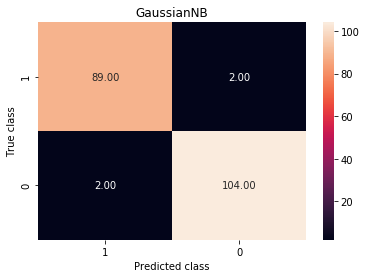

In [215]:
print(classification_report(y_test, g.predict(X_test_sfs)))
conf(g,X_test_sfs, y_test)

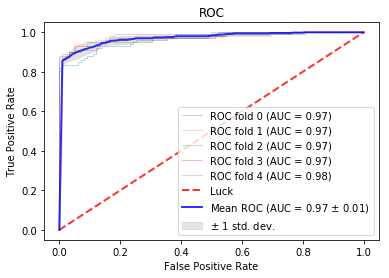

In [216]:
roc_graph_cv(g,X[:,selectedFeatures],y)

In [217]:
# print (results_test)

df_test =pd.DataFrame(list(results_test.items()),
                      columns=['Algorithm,'Test_Acc'])
df_train =pd.DataFrame(list(results_train.items()),
                      columns=['Algorithm','Train_Acc'])
df_results = df_test.join(df_train.set_index('Algorithm'), on='Algorithm')
df_results.sort_values('Test_Acc',ascending=False)

,Algorithm,Test_Acc,Train_Acc
12,SVC_sfs,98.48,92.88
7,ExtraTreesClassifier_sfs,98.48,100.00
5,LogisticRegression_sfs,97.97,92.76
24,GaussianNB_sfs,97.97,91.99
3,RandomForestClassifier_sfs,97.97,100.00
6,ExtraTreesClassifier_,97.46,100.00
2,RandomForestClassifier_,97.46,100.00
13,SVC_linear,97.46,94.16
4,LogisticRegression_,96.95,93.90
20,AdaBoostClassifier_sfs,96.95,97.20
